# Mission 2 : Réaliser une classification supervisée d'images

##### Test de l’API OpenFood Facts – Extraction de produits à base de “champagne”

Une API (Interface de Programmation d’Application) permet à deux programmes de communiquer entre eux.  
Ici, nous allons demander à OpenFood Facts de nous envoyer des informations sur des produits contenant du "champagne".

Pour cela, nous allons :
- Envoyer une requête (demande) à l’API.
- Recevoir une réponse (données) au format JSON (facile à utiliser en Python).

In [1]:
import requests  # Pour envoyer des requêtes à l’API
import pandas as pd  

# Affichage des images des produits
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO

## 1. Définir l’URL et les paramètres de la requête API (OpenFoodFacts)

- L’URL est l’adresse de l’API.
- Les paramètres précisent ce que nous voulons veux chercher (ici, les produits contenant "champagne").

In [2]:
# Recherche simple 
url = "https://world.openfoodfacts.org/cgi/search.pl"
params_v1 = {
    "search_terms": "champagne",
    "search_simple": 1,
    "action": "process",
    "json": 1,
    "page_size": 50
}

- `search_terms` : On cherche les produits liés au mot clé « champagne ».
- `search_simple` : Recherche simple (plein texte).
Search_simple=0 : recherche avancée.
Utiliser d’autres paramètres pour cibler précisément la recherche 
- `action` : Indique à l’API de traiter la requête.
- `json` : Demande une réponse au format JSON (facile à manipuler en Python).
- `page_size` : On demande 50 résultats pour avoir un échantillon.

##### Limites de la première version du filtrage

La première version du script extrait les produits contenant le mot "champagne" dans la liste des ingrédients, sans distinction.  
Cependant, cette méthode présente plusieurs limites :

- **Manque de précision** : Le mot "champagne" peut apparaître dans d'autres contextes, par exemple pour désigner la région d'origine du produit ("biscuit de Reims, région Champagne") ou dans des noms de produits qui ne contiennent pas réellement la boisson alcoolisée "champagne".
- **Résultats non pertinents** : Certains produits sélectionnés ne sont pas à base de champagne (la boisson), mais simplement liés à la région ou à des recettes utilisant le terme "champagne" de façon générique.
- **Bruit dans les données** : Cette approche peut introduire du bruit dans l’analyse, car elle inclut des produits qui ne correspondent pas à la cible recherchée pour l’élargissement de la gamme à l’épicerie fine.

**Conclusion** :  
Pour répondre précisément à la demande du projet, il est nécessaire d’affiner le filtrage afin de ne retenir que les produits dont "champagne" est un ingrédient réel, et d’exclure les produits simplement associés à la région ou à d’autres

In [10]:
# Recherche avancée et filtrage plus strict
params_v2 = {
    "search_terms": "champagne",
    "search_simple": 1,
    "action": "process",
    "json": 1,
    "page_size": 50,
    "tagtype_0": "ingredients",
    "tag_contains_0": "contains",
    "tag_0": "champagne"
}

##### Paramètres choisis pour la recherche avancée et le filtrage plus strict

Pour améliorer la pertinence des résultats et ne sélectionner que les produits contenant réellement "champagne" comme ingrédient, les paramètres suivants ont été utilisés :

- **search_terms** : `"champagne"`  
  Mot-clé recherché dans la base de données. Il permet de cibler les produits liés à ce terme.

- **search_simple** : `1`  
  Effectue une recherche en texte simple. Cela permet d’élargir la recherche à tous les champs pertinents.

- **action** : `"process"`  
  Indique à l’API de traiter la requête et de renvoyer les résultats.

- **json** : `1`  
  Demande une réponse au format JSON, plus facile à manipuler en Python.

- **page_size** : `50`  
  Nombre de résultats à récupérer (ici, 50 pour avoir un échantillon suffisamment large).

- **tagtype_0** : `"ingredients"`  
  Spécifie que le filtre porte sur les ingrédients du produit.

- **tag_contains_0** : `"contains"`  
  Indique que l’on souhaite uniquement les produits dont la liste d’ingrédients contient le tag spécifié.

- **tag_0** : `"champagne"`  
  Précise que l’ingrédient recherché est "champagne".

**Résumé** :  
Grâce à ces paramètres, la requête cible uniquement les produits dont "champagne" est explicitement mentionné comme ingrédient, ce qui permet d’exclure les produits simplement liés à la région Champagne ou à d’autres usages du mot. Cela améliore la qualité et la pertinence des données extraites pour

## 2. Envoyer la requête à l’API et récupérer la réponse

Nous allons maintenant envoyer notre demande à l’API et récupérer les données.

In [3]:
response_v1 = requests.get(url, params=params_v1)
data_v1 = response_v1.json()

In [11]:
response_v2 = requests.get(url, params=params_v2)
data_v2 = response_v2.json()

## 3. Extraire et filtrer les informations utiles

On ne garde que les produits qui contiennent "champagne" dans la liste des ingrédients,  et on extrait seulement les champs demandés : foodId, label, category, foodContentsLabel, image.

Nous allons maintenant envoyer notre demande à l’API et récupérer les données.

In [5]:
products_v1 = []
for product in data_v1.get("products", []):
    ingredients = product.get("ingredients_text", "") or ""
    if "champagne" in ingredients.lower():
        products_v1.append({
            "foodId": product.get("code", ""),
            "label": product.get("product_name", ""),
            "category": product.get("categories", ""),
            "foodContentsLabel": ingredients,
            "image": product.get("image_url", "")
        })
    if len(products_v1) == 10:
        break

--> Parcourt tous les produits reçus de l’API, sélectionne ceux dont les ingrédients contiennent le mot "champagne", extrait certaines informations utiles pour chacun, et s’arrête dès qu’il en a trouvé 10.

Si le produit contient "champagne", on crée un dictionnaire avec :

- foodId : l’identifiant unique du produit,
- label : le nom du produit,
- category : la ou les catégories du produit,
- foodContentsLabel : la liste des ingrédients,
- image : l’URL de l’image du produit (si disponible).

Ce dictionnaire est ajouté à la liste products. Dès que la liste contient 10 produits, on arrête la boucle pour ne garder qu’un échantillon limité.


In [12]:
products_v2 = []
for product in data_v2.get("products", []):
    ingredients = product.get("ingredients_text", "") or ""
    category = product.get("categories", "").lower()
    # On filtre les produits où "champagne" est un ingrédient isolé, pas une mention géographique
    ingr_list = [i.strip() for i in ingredients.lower().replace('.', ',').split(',')]
    if "champagne" in ingr_list and not any(x in category for x in ["région", "biscuit", "pâtisserie"]):
        products_v2.append({
            "foodId": product.get("code", ""),
            "label": product.get("product_name", ""),
            "category": product.get("categories", ""),
            "foodContentsLabel": ingredients,
            "image": product.get("image_url", "")
        })
    if len(products_v2) == 10:
        break

``
ingredients = product.get("ingredients_text", "") or ""
category = product.get("categories", "").lower()
``

- ingredients : texte brut de la liste des ingrédients du produit (ou chaîne vide si absent).
- category : catégories du produit, converties en minuscules pour faciliter le filtrage.

``
if "champagne" in ingr_list and not any(x in category for x in ["région", "biscuit", "pâtisserie"]):
``

- Condition 1 : "champagne" doit être un ingrédient isolé dans la liste (ingr_list).
- Condition 2 : On exclut les produits dont la catégorie contient "région", "biscuit" ou "pâtisserie" (pour éviter les faux positifs liés à la région ou à des recettes).

``
products_v2.append({
    "foodId": product.get("code", ""),
    "label": product.get("product_name", ""),
    "category": product.get("categories", ""),
    "foodContentsLabel": ingredients,
    "image": product.get("image_url", "")
})
``

Ajout du produit filtré et si le produit passe le filtre, on extrait les champs demandés et on l’ajoute à la liste.

``
if len(products_v2) == 10:
    break
``

On arrête la boucle dès qu’on a 10 produits valides, pour limiter la taille de l’échantillon.

Ces tags (tagtype_0, tag_contains_0, tag_0) sont des paramètres avancés de filtrage proposés par l’API OpenFood Facts : https://wiki.openfoodfacts.org/API_Fields
Ils permettent de cibler précisément certains champs et valeurs dans la base de données.

- tagtype_0="ingredients" : indique à l’API de filtrer sur le champ “ingrédients” du produit.
- tag_contains_0="contains" : précise que l’on veut les produits dont la liste d’ingrédients contient la valeur recherchée.
- tag_0="champagne" : indique la valeur recherchée dans le champ “ingrédients” (ici, l’ingrédient “champagne”).

## 4. Sauvegarder les données dans un fichier CSV

In [6]:
df_v1 = pd.DataFrame(products_v1)
df_v1.to_csv("champagne_products_v1.csv", index=False)
print("Version 1 : Fichier 'champagne_products_v1.csv' créé avec succès !")

Version 1 : Fichier 'champagne_products_v1.csv' créé avec succès !


In [13]:
df_v2 = pd.DataFrame(products_v2)
df_v2.to_csv("champagne_products_v2.csv", index=False)
print("Version 2 : Fichier 'champagne_products_v2.csv' créé avec succès !")

Version 2 : Fichier 'champagne_products_v2.csv' créé avec succès !


### 4.1 Visualiser le DataFrame des produits

In [7]:
df_v1.head(10)  # Affiche les 10 premiers produits

,foodId,label,category,foodContentsLabel,image
0,4056489843696,Rillettes de homard au cognac,"Seafood, Fishes and their products, Fish prepa...","Chair de homard américain 49%, huile de colza,...",https://images.openfoodfacts.org/images/produc...
1,3258431220000,,"Boissons, Boissons alcoolisées, Vins, Vins eff...",Champagne,https://images.openfoodfacts.org/images/produc...
2,3049610004104,Veuve Clicquot Champagne Ponsardin Brut,"Boissons et préparations de boissons, Boissons...",Champagne,https://images.openfoodfacts.org/images/produc...
3,3282946015837,Nicolas Feuillatte,"Boissons, Boissons alcoolisées, Vins, Vins fra...","Champagne, Contient des _sulfites_",https://images.openfoodfacts.org/images/produc...
4,3560070962334,Miel de la Champagne,"Petit-déjeuners, Produits à tartiner, Produits...",Miel de la Champagne (France).,https://images.openfoodfacts.org/images/produc...
5,3113910312013,Champagne Alfred Rothschild et Cie brut,"Boissons, Boissons alcoolisées, Vins, Vins fra...",Champagne brut (contient _sulfites_),https://images.openfoodfacts.org/images/produc...
6,4061463055538,Edle Trüffel - Marc de Champagne,"Imbiss, Süßer Snack, Kakao und Kakaoprodukte, ...","Zucker, Kakaomasse, Kakaobutter, Marc de Champ...",https://images.openfoodfacts.org/images/produc...
7,3185370283905,Champagne Ruinart,"Boissons, Boissons alcoolisées, Vins, Vins eff...",champagne,https://images.openfoodfacts.org/images/produc...
8,3250391764426,Préparation de Rhubarbe de Champagne Ardenne,"Aliments et boissons à base de végétaux, Alime...","Rhubarbe de Champagne Ardenne(65%), sucre de c...",https://images.openfoodfacts.org/images/produc...
9,3270271513050,Tripes mijotées à l'Ancienne et cuisinées à la...,"Plats-cuisinees,Plats préparés,Tripes","estomacs de boœuf (origine France), eau, oigno...",https://images.openfoodfacts.org/images/produc...


In [14]:
df_v2.head(10)  # Affiche les 10 premiers produits

,foodId,label,category,foodContentsLabel,image
0,3258431220000,,"Boissons, Boissons alcoolisées, Vins, Vins eff...",Champagne,https://images.openfoodfacts.org/images/produc...
1,3282946015837,Nicolas Feuillatte,"Boissons, Boissons alcoolisées, Vins, Vins fra...","Champagne, Contient des _sulfites_",https://images.openfoodfacts.org/images/produc...
2,3049610004104,Veuve Clicquot Champagne Ponsardin Brut,"Boissons et préparations de boissons, Boissons...",Champagne,https://images.openfoodfacts.org/images/produc...
3,3416181017169,"Champagne AOP, brut","Boissons, Boissons alcoolisées, Vins, Vins eff...",Champagne,https://images.openfoodfacts.org/images/produc...
4,3185370283905,Champagne Ruinart,"Boissons, Boissons alcoolisées, Vins, Vins eff...",champagne,https://images.openfoodfacts.org/images/produc...
5,3267852534122,Champagne Charles Lafitte Belle Cuvée Brut,"Boissons, Boissons alcoolisées, Vins, Vins eff...",Champagne,https://images.openfoodfacts.org/images/produc...
6,3113870000029,Champagne,"Boissons, Boissons alcoolisées, Vins, Vins eff...",Champagne,https://images.openfoodfacts.org/images/produc...
7,3113930004103,Champagne Brut,"Boissons, Boissons alcoolisées, Vins, Vins fra...","Champagne, contient des _sulfites_.",https://images.openfoodfacts.org/images/produc...
8,3113934000538,Champagne - cuvée Charles VII,"Boissons, Boissons alcoolisées, Vins, Vins fra...",CHAMPAGNE,https://images.openfoodfacts.org/images/produc...
9,26011387,Champagne Veuve Durand,"Boissons, Boissons alcoolisées, Vins, Vins fra...",Champagne,https://images.openfoodfacts.org/images/produc...


In [8]:
# Afficher les catégories les plus fréquentes
df_v1['category'].value_counts().head(10)

category
Boissons, Boissons alcoolisées, Vins, Vins français, Vins effervescents, Champagnes, Champagnes français, Champagnes bruts                                                                                                                                                                                          2
Seafood, Fishes and their products, Fish preparations, fr:Rillettes de homard au cognac et champagne, en:lobster-rillettes                                                                                                                                                                                          1
Boissons, Boissons alcoolisées, Vins, Vins effervescents, Champagnes, Champagnes bruts                                                                                                                                                                                                                              1
Boissons et préparations de boissons, Boissons, Boissons alco

In [15]:
# Afficher les catégories les plus fréquentes
df_v2['category'].value_counts().head(10)

category
Boissons, Boissons alcoolisées, Vins, Vins effervescents, Champagnes                                                          3
Boissons, Boissons alcoolisées, Vins, Vins effervescents, Champagnes, Champagnes bruts                                        2
Boissons, Boissons alcoolisées, Vins, Vins français, Vins effervescents, Champagnes, Champagnes français, Champagnes bruts    2
Boissons, Boissons alcoolisées, Vins, Vins français, Vins effervescents, Champagnes, Champagnes français                      2
Boissons et préparations de boissons, Boissons, Boissons alcoolisées, Vins, Vins effervescents, Champagnes                    1
Name: count, dtype: int64

In [9]:
df_v1['label']

0                        Rillettes de homard au cognac
1                                                     
2              Veuve Clicquot Champagne Ponsardin Brut
3                                   Nicolas Feuillatte
4                                 Miel de la Champagne
5              Champagne Alfred Rothschild et Cie brut
6                     Edle Trüffel - Marc de Champagne
7                                    Champagne Ruinart
8         Préparation de Rhubarbe de Champagne Ardenne
9    Tripes mijotées à l'Ancienne et cuisinées à la...
Name: label, dtype: object

In [16]:
df_v2['label']

0                                              
1                            Nicolas Feuillatte
2       Veuve Clicquot Champagne Ponsardin Brut
3                           Champagne AOP, brut
4                             Champagne Ruinart
5    Champagne Charles Lafitte Belle Cuvée Brut
6                                     Champagne
7                                Champagne Brut
8                 Champagne - cuvée Charles VII
9                        Champagne Veuve Durand
Name: label, dtype: object

### 4.2 Visualiser les images des produits

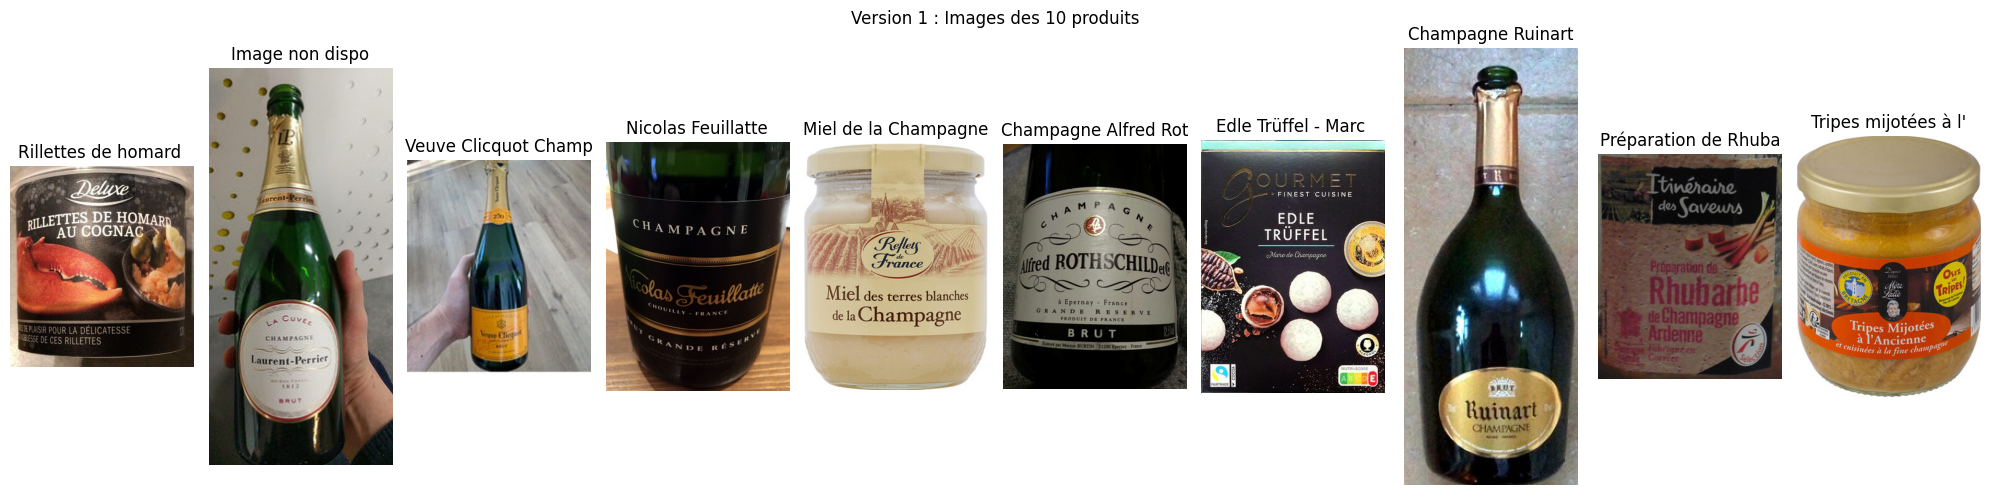

In [17]:
df_v1 = pd.read_csv("champagne_products.csv")  # Ton fichier existant

fig, axes = plt.subplots(1, min(10, len(df_v1)), figsize=(20, 5))
for idx, (i, row) in enumerate(df_v1.iterrows()):
    if idx >= 10:
        break
    url = row['image']
    if pd.notnull(url) and url != "":
        try:
            response = requests.get(url)
            img = Image.open(BytesIO(response.content))
            axes[idx].imshow(img)
            axes[idx].set_title(row['label'][:20])
            axes[idx].axis('off')
        except Exception:
            axes[idx].set_title("Image non dispo")
            axes[idx].axis('off')
    else:
        axes[idx].set_title("Pas d'image")
        axes[idx].axis('off')
plt.suptitle("Version 1 : Images des 10 produits")
plt.tight_layout()
plt.show()

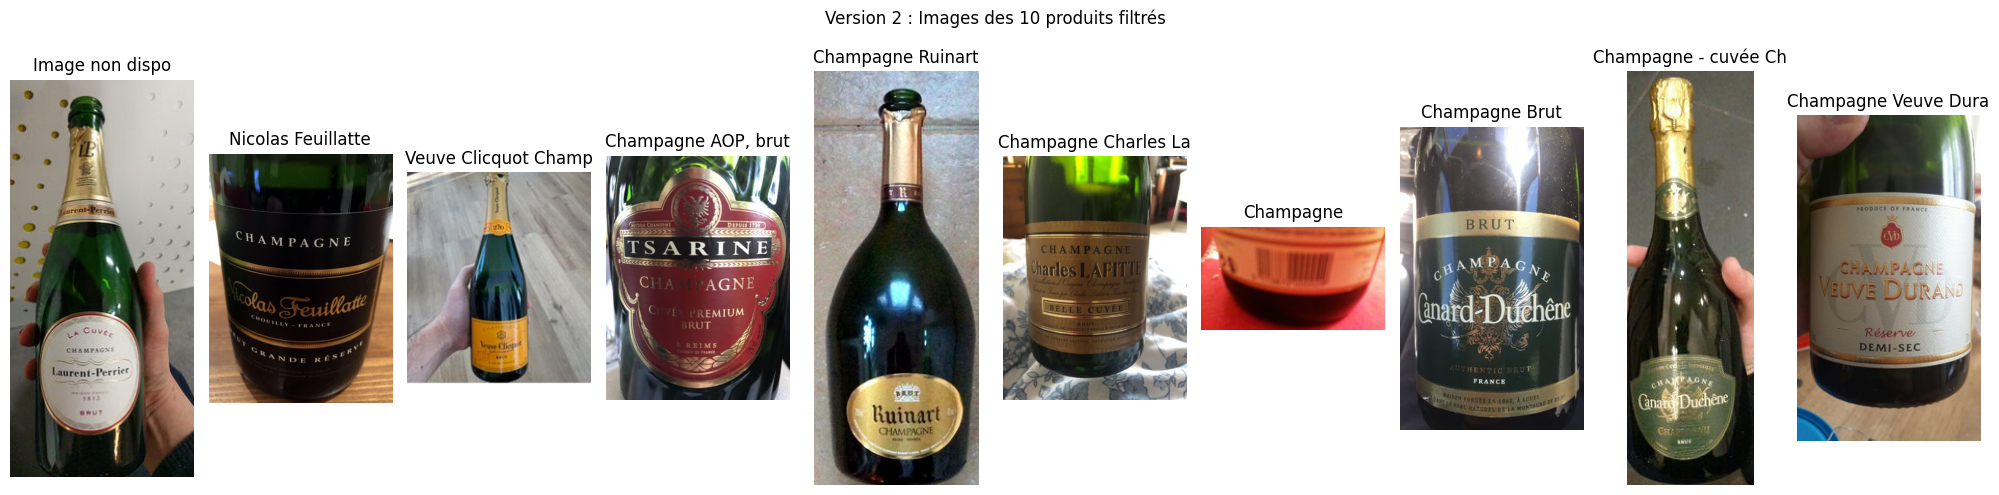

In [18]:
df_v2 = pd.read_csv("champagne_products_v2.csv")  # Fichier de la version filtrée

fig, axes = plt.subplots(1, min(10, len(df_v2)), figsize=(20, 5))
for idx, (i, row) in enumerate(df_v2.iterrows()):
    if idx >= 10:
        break
    url = row['image']
    if pd.notnull(url) and url != "":
        try:
            response = requests.get(url)
            img = Image.open(BytesIO(response.content))
            axes[idx].imshow(img)
            axes[idx].set_title(row['label'][:20])
            axes[idx].axis('off')
        except Exception:
            axes[idx].set_title("Image non dispo")
            axes[idx].axis('off')
    else:
        axes[idx].set_title("Pas d'image")
        axes[idx].axis('off')
plt.suptitle("Version 2 : Images des 10 produits filtrés")
plt.tight_layout()
plt.show()

## 5.  Checklist RGPD – Respect des 5 grands principes

##### Checklist RGPD – Respect des 5 grands principes (selon la CNIL)

- **Principe de finalité** : Les données sont collectées uniquement pour l’analyse de faisabilité du projet d’élargissement de gamme à l’épicerie fine.
- **Principe de proportionnalité et de pertinence** : Seuls les champs strictement nécessaires sont extraits (`foodId`, `label`, `category`, `foodContentsLabel`, `image`).
- **Principe d’une durée de conservation limitée** : Les données sont stockées localement et uniquement pour la durée du projet.
- **Principe de sécurité et de confidentialité** : Les données sont stockées sur un poste sécurisé, sans diffusion externe, et aucune donnée personnelle n’est collectée.
- **Droits des personnes** : Les données proviennent d’une base publique et collaborative, sans collecte d’informations personnelles, respectant ainsi les droits des personnes concernées.

**Conclusion** : La collecte respecte les exigences RGPD et les attendus du projet.